### Competition:
Toxic Comment Classification Challenge: Identify and classify toxic online comments

#### Challenge Link:
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge


#### Introduction
Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

In [95]:
#import required packages
#basics
import pandas as pd 
import numpy as np
from utils import *

# visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
import missingno as msno

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

#text cleaning
import re
import string
import collections
from nltk import pos_tag
from nltk.corpus import stopwords

In [2]:
train = pd.read_csv("../Toxic Comments/train.csv")
test = pd.read_csv("../Toxic Comments/test.csv")

# Section 1: EDA

#### Check missing values for Train and Test:

There are no missing values for train and test data

In [3]:
cal_missing_val(train)

,MissingValueInPercentage
id,0.0
comment_text,0.0
toxic,0.0
severe_toxic,0.0
obscene,0.0
threat,0.0
insult,0.0
identity_hate,0.0


In [4]:
cal_missing_val(test)

,MissingValueInPercentage
id,0.0
comment_text,0.0


#### Get a comment column as a Clean

- whenever there is zero toxicity, that column is a clean column

In [5]:
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)*1

#### Get a distribution of tag within each catergory

In [6]:
df1 = pd.DataFrame(train.loc[:,"toxic"].value_counts())
df2 = pd.DataFrame(train.loc[:,"severe_toxic"].value_counts())
df3 = pd.DataFrame(train.loc[:,"obscene"].value_counts())
df4 = pd.DataFrame(train.loc[:,"threat"].value_counts())
df5 = pd.DataFrame(train.loc[:,"insult"].value_counts())
df6 = pd.DataFrame(train.loc[:,"identity_hate"].value_counts())
df_train_distribution = pd.concat([df1,df2,df3,df4,df5,df6], axis = 1)
df_train_distribution

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


In [7]:
train_col_name = train.columns.drop(["id","comment_text","clean"]).tolist()

In [141]:
percentage_of_1 = []
for i in range(len(train_col_name)):
    a = round(df_train_distribution.iloc[1,i]/(df_train_distribution.iloc[1,i]+df_train_distribution.iloc[0,i])*100,2)
    percentage_of_1.append(a)

In [142]:
percentage_of_1

[9.58, 1.0, 5.29, 0.3, 4.94, 0.88]

#### Using MSNO to visually check relationship between category tags for each comment

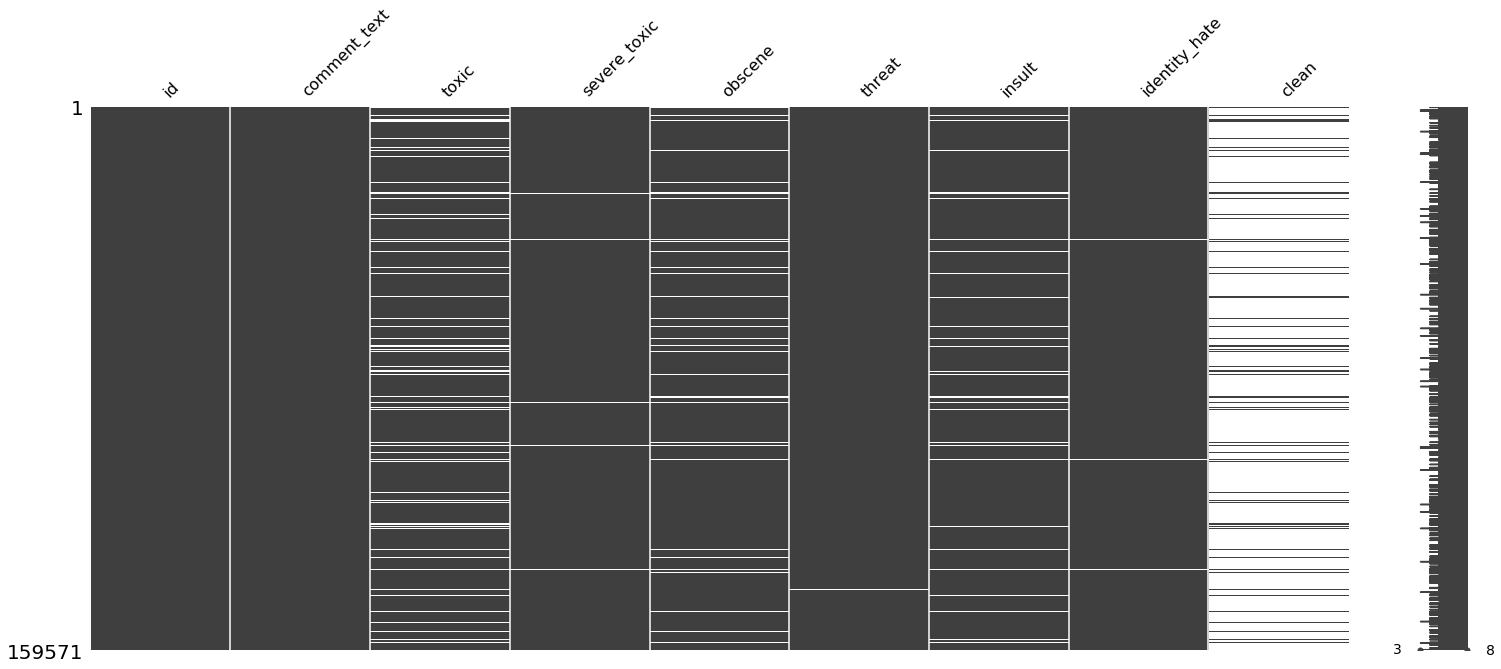

In [10]:
train_msno = train.replace(1,float("NaN"))
# checking overlaps among 6 columns
msno.matrix(train_msno)

In [11]:
#larger percentage, larger proportion explained by other factors 

# severe_toxic
print(1-(train[train.severe_toxic == 1].severe_toxic - train[train.severe_toxic == 1].toxic).sum()) # 100% explained by toxic 

1


In [12]:
# identity_hate
number_identity_hate = len(train[train.identity_hate == 1].identity_hate)
print(1-(train[train.identity_hate == 1].identity_hate - train[train.identity_hate == 1].insult).sum()/number_identity_hate) #83% explained by insult
print(1-(train[train.identity_hate == 1].identity_hate - train[train.identity_hate == 1].toxic).sum()/number_identity_hate) #93% expalined by toxic
print(1-(train[train.identity_hate == 1].identity_hate - train[train.identity_hate == 1].severe_toxic).sum()/number_identity_hate) #22% expalined by severe_toxic
print(1-(train[train.identity_hate == 1].identity_hate - train[train.identity_hate == 1].obscene).sum()/number_identity_hate) #73% expalined by obscene

0.8256227758007118
0.9266903914590747
0.22277580071174374
0.7345195729537366


In [13]:
# threat
number_threat = len(train[train.threat == 1].threat)
print(1-(train[train.threat == 1].threat - train[train.threat == 1].insult).sum()/number_threat) #64% explained by insult
print(1-(train[train.threat == 1].threat - train[train.threat == 1].toxic).sum()/number_threat) #94% expalined by toxic
print(1-(train[train.threat == 1].threat - train[train.threat == 1].severe_toxic).sum()/number_threat) #24% expalined by severe_toxic
print(1-(train[train.threat == 1].threat - train[train.threat == 1].obscene).sum()/number_threat) #63% expalined by obscene

0.6422594142259415
0.9393305439330544
0.2343096234309623
0.6297071129707112


#### Conclusion: threat, identity_date, severe_toxic are heavily explained (overlapped) by with toxic 

#### comments distributino by number of tags 

In [14]:
train["number_tags"] = train.toxic+train.severe_toxic+train.obscene+train.threat+train.insult+train.identity_hate

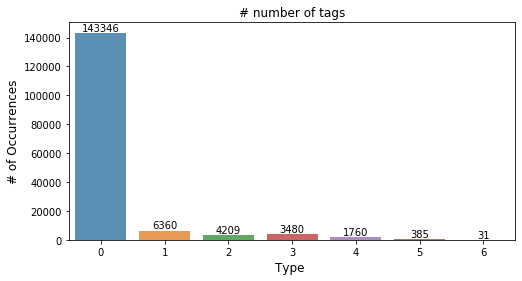

In [15]:
x = train.number_tags.value_counts().index
y = train.number_tags.value_counts().values

plt.figure(figsize=(8,4))
ax= sns.barplot(x, y, alpha=0.8)
plt.title("# number of tags")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = y
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

#### check predicted class imbalance

- There is a high imbalance for predicted class

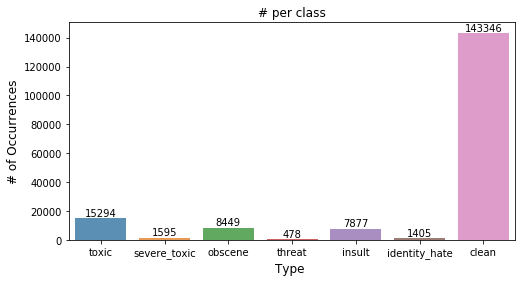

In [16]:
xxx=train.iloc[:,2:9].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(xxx.index, xxx.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = xxx.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

#### Get combination for different columns

- Combinations of a column tell us overlap between comments

In [17]:
df_comb = train.groupby(train_col_name).size().sort_values(ascending=False).reset_index().rename(columns={0: 'count'})
print(len(df_comb))
df_comb.head()

41


,toxic,severe_toxic,obscene,threat,insult,identity_hate,count
0,0,0,0,0,0,0,143346
1,1,0,0,0,0,0,5666
2,1,0,1,0,1,0,3800
3,1,0,1,0,0,0,1758
4,1,0,0,0,1,0,1215


#### The correlation matrix shows interesting things :

'toxic' is clearly correlated with 'obscene' and 'insult' (0.68 and 0.65)
'toxic' and 'severe_toxic' are only got a 0.31 correlation factor
'insult' and 'obscene' have a correlation factor of 0.74
From my point of view, there are several combinations that are worth digging into :

'toxic' <-> 'severe_toxic'. The semantic of these two categories seems to show some kind of graduation between them
'toxic' <-> 'insult' and 'toxic' <-> 'obscene'
'insult' <-> 'obscene'

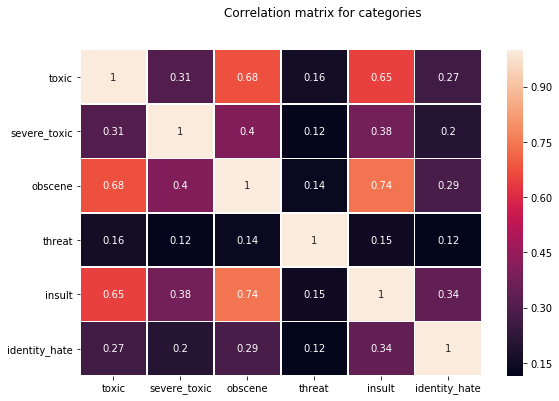

In [18]:
f, ax = plt.subplots(figsize=(9, 6))
f.suptitle('Correlation matrix for categories')
sns.heatmap(train[train_col_name].corr(), annot=True, linewidths=.5, ax=ax)

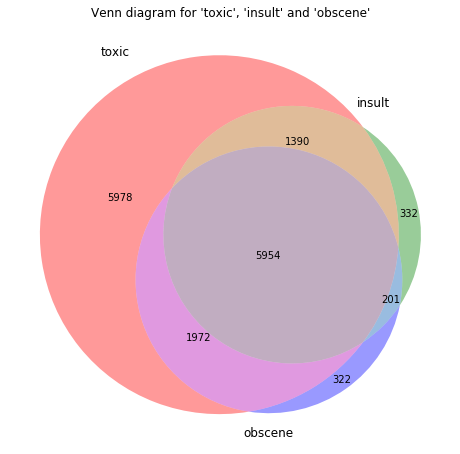

In [19]:
t = train[(train['toxic'] == 1) & (train['insult'] == 0) & (train['obscene'] == 0)].shape[0]
i = train[(train['toxic'] == 0) & (train['insult'] == 1) & (train['obscene'] == 0)].shape[0]
o = train[(train['toxic'] == 0) & (train['insult'] == 0) & (train['obscene'] == 1)].shape[0]

t_i = train[(train['toxic'] == 1) & (train['insult'] == 1) & (train['obscene'] == 0)].shape[0]
t_o = train[(train['toxic'] == 1) & (train['insult'] == 0) & (train['obscene'] == 1)].shape[0]
i_o = train[(train['toxic'] == 0) & (train['insult'] == 1) & (train['obscene'] == 1)].shape[0]

t_i_o = train[(train['toxic'] == 1) & (train['insult'] == 1) & (train['obscene'] == 1)].shape[0]


# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic', 'insult' and 'obscene'")
venn3(subsets = (t, i, t_i, o, t_o, i_o, t_i_o), 
      set_labels=('toxic', 'insult', 'obscene'))
plt.show()

#### Wordclouds - Frequent words:
Now, let's take a look at words that are associated with these classes.

Chart Desc: The visuals here are word clouds (ie) more frequent words appear bigger. A cool way to create word clouds with funky pics is given here. It involves the following steps.

* Search for an image and its base 64 encoding
* Paste encoding in a cell and convert it using codecs package to image
* Create word cloud with the new image as a mask
A simpler way would be to create a new kaggle dataset and import images from there.

In [20]:
from wordcloud import WordCloud ,STOPWORDS
stopword=set(STOPWORDS)

def get_word_cloud(column):
    subset=train[train[column]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
    wc.generate(" ".join(text))
    plt.figure(figsize=(20,10))
    plt.axis("off")
    plt.title("Words frequented in Clean Comments", fontsize=20)
    plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
    plt.show()

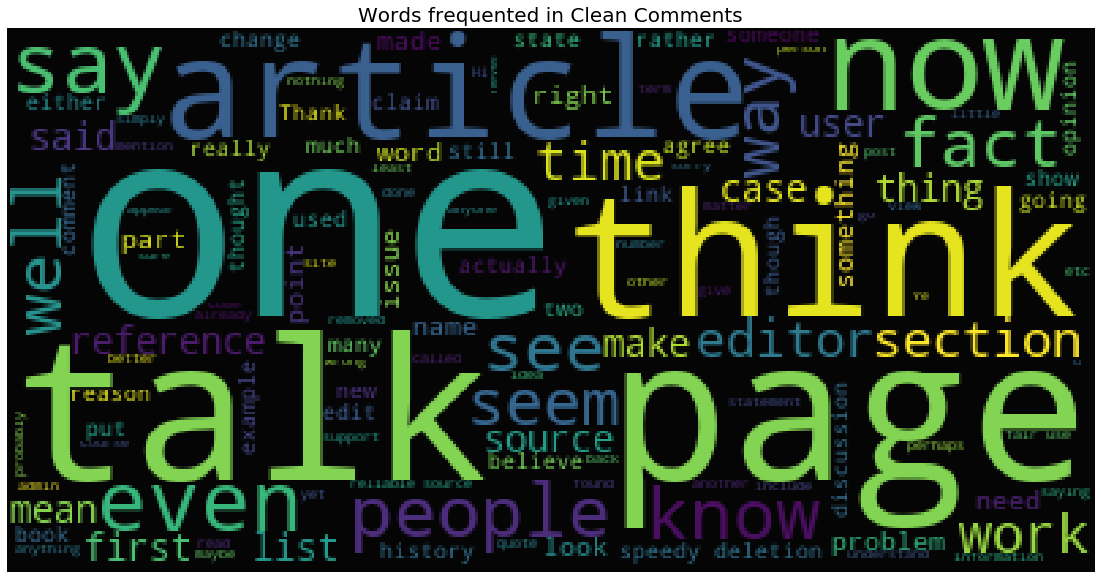

In [21]:
get_word_cloud('clean')   #wordcloud for clean comments

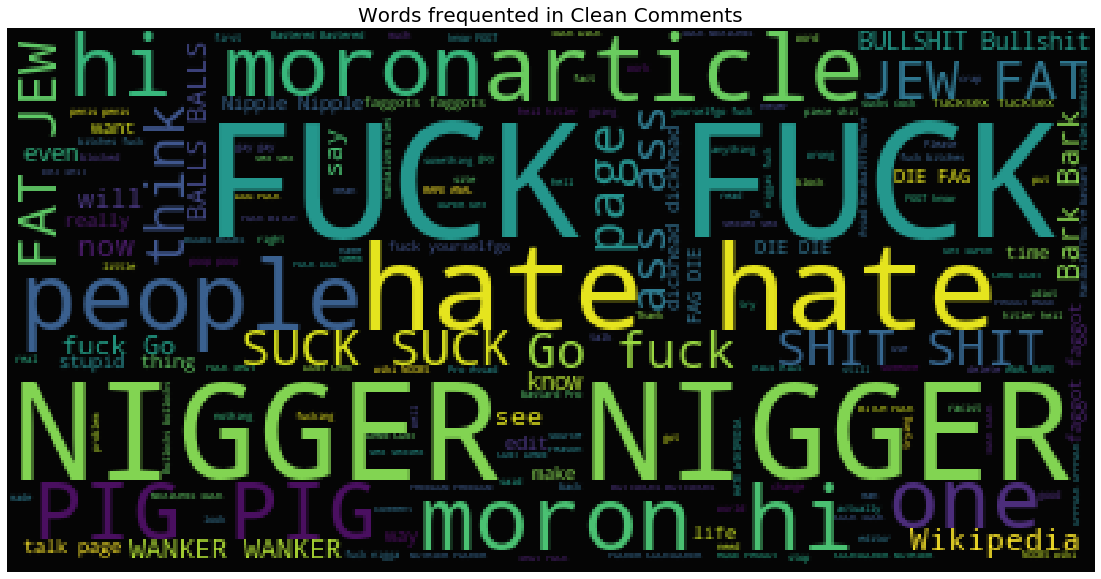

In [22]:
get_word_cloud('toxic')

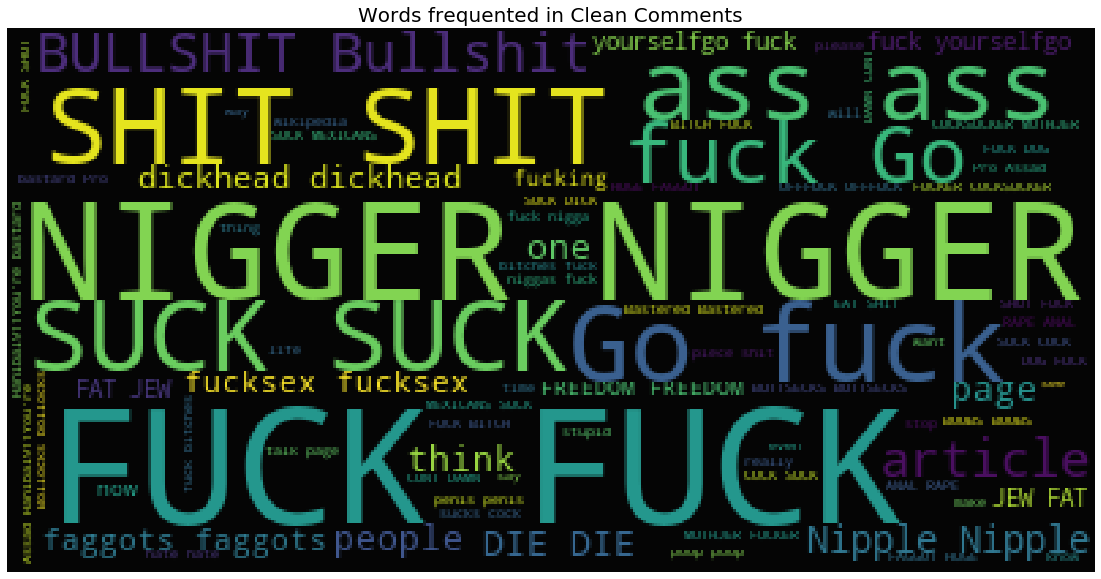

In [23]:
get_word_cloud('obscene')

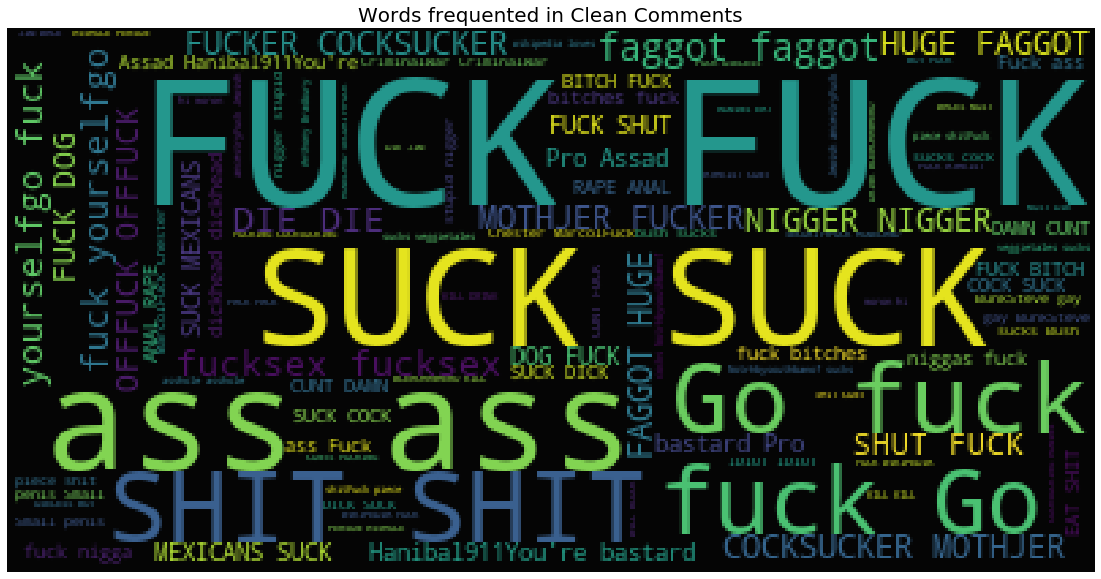

In [24]:
get_word_cloud('severe_toxic')

# Section 2: Text cleaning 

In [ ]:
def find_all_ip(df):
    ip_list = []
    for ip in range(len(df.comment_text)+1):
        a = re.findall( r'[0-9]+(?:\.[0-9]+){3}', df.comment_text.tolist()[i])
        ip_list.append(a)
    return ip_list

In [138]:
def text_cleatning(df):
    ###### replacing emojis or abbreviations: ######
    repl = {
    "yay!": " good ",
    "yay": " good ",
    "yaay": " good ",
    "yaaay": " good ",
    "yaaaay": " good ",
    "yaaaaay": " good ",
    '''
    ":')": " sad ",
    ":-(": " sad ",
    ":(": " sad ",
    ":s": " sad ",
    ":-s": " sad ",
    ":/": "sad",
    ":')": " sad ",
    ":-(": " sad ",
    ":(": " sad ",
    ":d": " happy ",
    ":p": " happy ",
    ":dd": " happy ",
    "8)": " happy ",
    ":-)": " happy ",
    ":)": " happy ",
    ";)": " happy ",
    "(-:": " happy ",
    "(:": " happy ",
    '''
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bhaha\b": "ha",
    r"\bhahaha\b": "ha",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bwon't\b": "will not",
    r"\bwouldn't\b": "would not",
    r"\bcan't\b": "can not",
    r"\bcannot\b": "can not",
    r"\bi'm\b": "i am",
    "haha": "smile",
    "hahaha": "smile",
    "aren't" : "are not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "didn't" : "did not",
    "doesn't" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hasn't" : "has not",
    "haven't" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "i'd" : "I would",
    "i'd" : "I had",
    "i'll" : "I will",
    "i'm" : "I am",
    "isn't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "I have",
    "let's" : "let us",
    "mightn't" : "might not",
    "mustn't" : "must not",
    "shan't" : "shall not",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "shouldn't" : "should not",
    "that's" : "that is",
    "there's" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "weren't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "won't" : "will not",
    "wouldn't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "wasn't": "was not",
    "we'll":" will",
    }
    keys = [i for i in repl.keys()]
    new_comment = []
    ltr = df["comment_text"].tolist()
    for i in ltr:
        arr = str(i).split()
        xx = ""
        for j in arr:
            j = str(j).lower()
            if j[:4] == 'http' or j[:3] == 'www':
                continue
            if j in keys:
                j = repl[j]
            xx += j + " "
        new_comment.append(xx)
    df["clean_comment_text"] = new_comment
    
    
    ###### Cleaning data ######
    df.comment_text= df.comment_text.str.translate(str.maketrans('','',string.punctuation))
    df.comment_text = df.comment_text.str.replace("\n"," ")
    
    #New Feature: count of NEW LINES IN ONE COMMENT
    #Count it and remove it! 
    
    
    return(df)

In [140]:
def feature_creation(df):
    ###### Additional features for engineering ######
    df['num_words'] = df['comment_text'].apply(lambda comment: len(comment.split()))
    df['num_caps'] = df['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['percentage_cap'] = df['comment_text'].apply(lambda row: float(row['num_caps'])/float(row['num_words']),axis=1)
    df['num_symbol'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '#@*&$%!?'))
    df['num_happy'] = df['comment_text'].apply(lambda comment: 
                                               sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)',':d',":p",":dd","8)","(-:","(:")))
    df['num_unique_words'] = df['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['percentage_unique'] = df['num_unique_words'] / df['num_words']
    df['num_sad'] = df["comment_test"].apply(lambda comment: 
                                         sum(comment.count(w) for w in (":')",":-(",":(",":s",":-s",":/",":')",":-(",":(")))
    df['punctuation'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in string.punctuation))
    df['punctuation_vs_length'] = df['punctuation'] / df['total_length']
    df['punctuation_vs_words'] = df['punctuation'] / df['words']
    
    ###### Count repeated words ######
    def count_repeated(comment):
        '''
        remove stop words first here 
        '''
        
        repeated_threshold = 10 # 3,5,15....????
        text_splitted = comment.split()
        word_counts = collections.Counter(text_splitted)
        return sum(count for word, count in sorted(word_counts.items()) if count > repeated_threshold)
    
    df['num_rep_words'] = df['comment_text'].apply(lambda comment: count_repeated(comment))
    df['repeated_words_vs_length'] = df['num_rep_words'] / df['num_words']
    
    ###### Count number of adj, noun, verb ######
    def tag_part_of_speech(comment):
        text_splited = comment.split(' ')
        text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
        text_splited = [s for s in text_splited if s]
        pos_list = pos_tag(text_splited)
        noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
        adjective_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
        verb_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
        return[noun_count, adjective_count, verb_count]

    df['num_nouns'], df['num_adjectives'], df['num_verbs'] = zip(*df['comment_text'].apply(
    lambda comment: tag_part_of_speech(comment)))
    
    df['nouns_vs_words'] = df['nouns'] / df['num_words']
    df['adjectives_vs_words'] = df['adjectives'] / df['num_words']
    df['verbs_vs_words'] = df['verbs'] / df['num_words']
    
    ###### number of stop words ######
    eng_stopwords = stopwords.words("english")
    df['stopwords'] = df[COMMENT].apply(lambda comment: sum(comment.count(w) for w in eng_stopwords))
    df['stopwords_vs_length'] = df['stopwords'] / df['num_words']
    
    ###### number of exclamation marks ######
    train['exclamation_marks'] = train[COMMENT].apply(lambda comment: comment.count('!'))
    train['exclamation_marks_vs_length'] = train['exclamation_marks'] / train['num_words']
    
    ####
    # Remove stopwords after count the stopwords 
    
    
    return(df)

In [65]:
'''

features = ('num_words', 'num_caps', 'percentage_cap', 'num_symbol',
            'num_happy', 'num_unique_words', 'percentage_unique', 'num_sad')
columns = ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate')

rows = [{c:train[f].corr(train[c]) for c in columns} for f in features]
df_correlations = pd.DataFrame(rows, index=features)

'''

"\n\nfeatures = ('num_words', 'num_caps', 'percentage_cap', 'num_symbol',\n            'num_happy', 'num_unique_words', 'percentage_unique', 'num_sad')\ncolumns = ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate')\n\nrows = [{c:train[f].corr(train[c]) for c in columns} for f in features]\ndf_correlations = pd.DataFrame(rows, index=features)\n\n"